In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Broadcast
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
spark = SparkSession \
        .builder \
        .master('local') \
        .appName('restaurants') \
        .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.2') \
        .config('spark.mongodb.input.uri', 'mongodb://mongo/test.rests') \
        .config('spark.mongodb.output.uri', 'mongodb://mongo/test.rests') \
        .getOrCreate()

In [4]:
DF = spark.read.format('mongo').load()

In [5]:
DF.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- address: string (nullable = true)
 |-- check_group: string (nullable = true)
 |-- comments: struct (nullable = true)
 |    |-- comments__count: integer (nullable = true)
 |    |-- comments: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- comment__rating: double (nullable = true)
 |    |    |    |-- comment__body: string (nullable = true)
 |-- coords: struct (nullable = true)
 |    |-- coords__lat: double (nullable = true)
 |    |-- coords__lon: double (nullable = true)
 |-- district: string (nullable = true)
 |-- kitchen_types: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- name: string (nullable = true)
 |-- rating: struct (nullable = true)
 |    |-- rating__mean: double (nullable = true)
 |    |-- rating__food: double (nullable = true)
 |    |-- rating__service: double (nullable = true)
 |    |-- rating__price_quality: dou

In [6]:
SPbDistricts = [
    'адмиралтейский',
    'василеостровский',
    'выборгский',
    'калининский',
    'кировский',
    'колпинский',
    'красногвардейский',
    'красносельский',
    'кронштадтский',
    'курортный',
    'московский',
    'невский',
    'петроградский',
    'петродворцовый',
    'приморский',
    'пушкинский',
    'фрунзенский',
    'центральный'
]

In [7]:
# drop rows if main features is null or not in allowed list

df = DF.filter(DF['address'].isNotNull()) \
        .filter(DF['district'].isNotNull()) \
        .filter(DF['district'].isin(SPbDistricts)) \
        .filter(DF['coords'].isNotNull()) \
        .filter(DF['rating.rating__mean'].isNotNull())

In [8]:
# show some statistics

stats = df[['rating.*', 'comments.comments__count']].describe() \
            .select('summary',
                *(F.round(F.col(c), 5).alias(c)
                  for c in df[['rating.*', 'comments.comments__count']].columns))

stats.toPandas()

,summary,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,count,6747.00000,2632.00000,2646.00000,2637.00000,801.00000,6704.00000
1,mean,4.04743,4.15748,4.15835,4.06769,4.22971,40.48434
2,stddev,0.74047,0.50856,0.50034,0.50497,0.48635,132.96581
3,min,0.00000,1.50000,1.50000,1.50000,1.50000,1.00000
4,max,5.00000,5.00000,5.00000,5.00000,5.00000,3471.00000


In [9]:
# show average rate by districts

districts_rate = df[['district', 'rating.*']].groupBy('district').mean().sort(F.col('avg(rating__mean)').desc()) \
                    .select('district',
                        *(F.round(F.col('avg('+c+')'), 5).alias(c)
                            for c in df[['rating.*']].columns))

districts_rate.toPandas()

,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere
0,адмиралтейский,4.16903,4.17593,4.19676,4.10829,4.29063
1,центральный,4.15529,4.21398,4.22863,4.13980,4.27727
2,курортный,4.13757,4.16279,4.12500,4.02841,4.35000
3,петродворцовый,4.11824,4.22131,4.18852,4.02500,4.39286
4,петроградский,4.09853,4.14286,4.17478,4.01111,4.21795
5,василеостровский,4.07246,4.17500,4.10294,4.09901,4.18966
6,пушкинский,4.04412,4.13380,4.08333,4.00694,4.25000
7,московский,4.02116,4.15823,4.11950,4.05063,4.27551
8,приморский,3.97816,4.19658,4.19068,4.05128,4.21739
9,выборгский,3.97128,4.02465,4.03846,3.92806,4.26389


In [10]:
# show districts with count of restaurants kitchen types

# step 1 - collect kitchen types set (unique)
kitchen_types_dist = list(map(lambda x: x.col, list(set(df.select(F.explode('kitchen_types')).collect()))))

In [11]:
# step 2 - group kitchen types to set by district and then flatten nested arrays
kitchen_types_by_district = df[['district', 'kitchen_types']] \
    .groupBy('district').agg(F.collect_set('kitchen_types').alias('kitchen_types')) \
    .select('district', F.flatten('kitchen_types').alias('kitchen_types'))

kitchen_types_by_district.show()

+-----------------+--------------------+
|         district|       kitchen_types|
+-----------------+--------------------+
|    петроградский|[Японская, Европе...|
|      фрунзенский|[Европейская, Ита...|
|   адмиралтейский|[Европейская, Рус...|
|       выборгский|[Европейская, Рус...|
|   петродворцовый|[Средиземноморска...|
| василеостровский|[Японская, Суши, ...|
|красногвардейский|[Кафе, Русская, К...|
|          невский|[Гастропаб, Русск...|
|       московский|[Паб с пивоварней...|
|        кировский|[Европейская, Рус...|
|      калининский|[Европейская, Рус...|
|    кронштадтский|[Европейская, Пор...|
|       пушкинский|[Стейк-хаус, Евро...|
|       приморский|[Европейская, Паб...|
|   красносельский|[Восточноевропейс...|
|      центральный|[Американская, Ба...|
|        курортный|[Морепродукты, Ев...|
|       колпинский|[Итальянская, Евр...|
+-----------------+--------------------+



In [12]:
# function to calculate number of occurrences of a value in array in cell
@F.udf('int')
def number_of_in_array(col, target):
    n = 0
    for v in col:
        if v == target:
            n += 1
    return n

# step 3 - create collumns from set of kitchen types and
#     fill it with number of restaurants of this type
kitchen_types_by_district_counts = kitchen_types_by_district[['district', 'kitchen_types']] \
    .groupBy('district').agg(F.collect_set('kitchen_types').alias('kitchen_types')) \
    .select('district', F.flatten('kitchen_types').alias('kitchen_types')) \
    .select('district', (*(number_of_in_array('kitchen_types', F.lit(c)).alias(c) for c in kitchen_types_dist)))

kitchen_types_by_district_counts.toPandas()

,district,Кавказская,Морепродукты,Салон японских сладостей,Марокканская,Паб с пивоварней,Сингапурская,Кухня Эмилии-Романьи,Филиппинская,Чилийская,Израильская,Юговосточная,Шотландская,Пивные рестораны,Африканская,Испанская,Индийская,Малазийская,Голландская,Сицилийская,Индонезийская,Балти,Гриль,Лечебное питание,Венгерская,Датская,Центрально-итальянская,Фастфуд,Закусочная,Канадская,Ближневосточная,Хорватская,Пакистанская,Неаполитанская,Южноамериканская,Тунисская,Суши,Азиатская,Здоровая,Турецкая,Винный бар,Центральноамериканская,Бангладешская,Центральноевропейская,Американская,Пицца,Австрийская,Узбекская,Уличная еда,Кубинская,Фруктовые салоны,Кухня Кампании,Итальянская,Бары с рестораном,Кухня Ломбардии,Стейк-хаус,Шриланкийская,Шведская,Русская,Британская,Камбоджийская,Латышская,Бар,Бельгийская,Северно-итальянская,Аргентинская,Египетская,Немецкая,Костариканская,Корейская,Тайваньская,Словенская,Паб,Украинская,Супы,Средиземноморская,Грузинская,Каталанская,Гастроном,Тайская,Албанская,Карибская,Гавайская,Ливанская,Фьюжн,Азербайджанская,Современная,Кафе,Южно-итальянская,Пуэрториканская,Китайская,Восточноевропейская,Новозеландская,Чешская,Арабская,Мексиканская,Кухня Апулии,Римская,Швейцарская,Японская кухня-фьюжн,Норвежская,Австралийская,Гастропаб,Монгольская,Барбекю,Центральноазиатская,Европейская,Персидская,Международная,Тосканская,Французская,Перуанская,Вьетнамская,Армянская,Венесуэльская,Румынская,Ирландская,Тибетская,Кухня Лацио,Скандинавская,Греческая,Индейская,Каджунская и креольская,Португальская,Польская,Японская,Полинезийская,Латиноамериканская
0,петроградский,10,24,0,0,2,0,0,0,0,2,0,0,0,0,8,7,0,1,0,1,0,14,0,0,2,0,17,2,0,16,0,0,0,4,0,14,26,7,1,9,2,0,32,21,15,0,5,3,1,0,0,47,0,0,6,0,0,85,3,0,0,35,6,0,1,0,4,0,3,0,0,26,1,10,15,18,0,4,6,0,2,1,1,9,2,12,29,0,0,8,23,1,1,1,10,0,0,0,0,0,0,5,0,6,0,142,0,15,0,9,1,6,2,0,0,2,0,0,5,2,1,0,0,0,28,0,3
1,фрунзенский,1,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,10,3,0,4,0,0,0,0,0,4,4,2,1,0,0,0,3,2,5,1,1,0,1,0,0,11,0,0,0,0,0,23,1,1,0,8,0,0,0,0,0,0,1,1,0,10,0,1,1,5,0,0,1,0,1,0,0,2,3,2,6,0,0,3,5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,29,0,5,0,0,0,3,0,0,0,1,0,0,1,1,0,0,0,0,13,0,0
2,адмиралтейский,21,29,1,0,4,2,0,2,0,3,1,0,1,1,6,8,0,0,3,2,1,22,1,0,0,3,33,9,3,15,1,1,2,3,1,25,44,19,5,13,1,0,55,47,21,1,7,10,0,0,2,52,4,0,8,1,0,141,2,0,0,89,2,0,1,0,11,0,9,0,1,74,3,21,22,22,0,2,11,0,0,1,0,5,2,18,62,4,0,15,53,0,1,1,11,1,1,1,0,1,0,21,0,8,0,218,1,27,2,18,0,6,9,0,1,1,1,0,1,3,1,2,1,0,39,1,3
3,выборгский,11,9,0,0,4,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,9,0,0,0,0,12,3,0,14,0,1,0,2,0,17,16,0,5,2,0,0,9,18,18,0,6,2,1,0,0,26,0,0,3,0,1,54,0,0,0,20,1,0,0,0,3,1,2,0,1,20,2,10,8,15,0,1,2,0,1,0,0,1,6,4,13,0,0,6,26,1,3,0,4,0,0,1,0,0,0,3,0,4,0,84,0,11,0,5,0,1,4,0,1,3,0,0,0,1,0,0,0,0,23,0,2
4,петродворцовый,1,5,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,3,0,0,0,0,5,0,0,4,0,0,0,0,0,2,7,1,0,2,0,0,8,6,3,0,0,1,0,0,0,11,0,0,4,0,0,27,1,0,0,11,0,0,0,0,0,0,1,0,0,11,0,2,5,5,0,0,0,0,0,0,0,1,1,2,6,0,0,3,13,0,1,0,2,0,0,0,0,0,0,3,0,2,0,48,0,5,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,6,0,0
5,василеостровский,7,6,0,2,1,0,0,0,0,2,0,0,1,0,1,3,1,0,0,1,0,6,0,0,1,0,9,1,0,9,0,0,0,1,0,5,15,5,2,5,0,0,13,12,11,0,3,4,0,0,0,19,1,0,3,0,0,53,0,0,0,21,3,0,0,0,2,0,3,0,0,21,1,4,7,8,0,0,5,0,1,0,1,1,1,4,9,0,1,9,20,0,1,0,2,0,0,0,0,0,0,3,0,2,0,72,0,2,0,4,0,3,0,1,0,2,0,0,3,0,0,0,0,1,14,0,0
6,красногвардейский,4,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,6,0,0,4,0,0,1,0,0,10,9,0,1,1,0,0,6,5,10,1,3,0,0,0,1,14,0,0,0,0,0,29,0,0,0,7,0,0,0,0,2,0,0,0,0,10,0,0,1,4,0,0,1,0,0,0,0,1,0,2,8,1,0,4,9,1,1,1,3,0,0,0,0,0,0,2,0,2,0,38,0,6,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,12,0,0
7,невский,2,10,0,0,1,0,0,0,1,0,0,0,1,1,2,3,0,0,0,0,0,5,0,0,1,0,22,4,0,9,0,1,0,3,0,21,21,5,3,3,0,0,22,17,17,0,6,1,0,0,0,32,0,0,2,0,1,81,0,0,1,34,6,0,0,0,6,1,2,1,2,30,1,9,8,11,0,0,5,0,0,0,0,0,1,4,26,0,0,8,31,0,1,0,4,0,0,0,0,1,1,5,0,1,0,106,0,10,0,10,0,4,2,0,0,2,0,0,1,4,0,0,0,0,35,0,0
8,московский,16,11,0,0,2,0,0,0,0,0,1,1,1,0,4,0,0,0,0,0,0,10,0,0,1,0,14,8,0,6,0,0,0,2,0,16,22,5,0,3,0,0,19,21,18,0,1,0,0,0,0,42,1,0,6,1,0,59,4,0,0,

> warning: take a long time, be careful

In [ ]:
# (optional) step 4 - create dict of columns names and sum of values in this columns
kitchen_types_sum = {
    c: s for c, s in \
        zip(
            kitchen_types_by_district_counts.columns[1:],
            (kitchen_types_by_district_counts[[c_]].groupBy().sum().take(1)[0][0] \
                for c_ in kitchen_types_by_district_counts.columns[1:])
        )
}

# sort dict by values
kitchen_types_sum = {k: v for k, v in sorted(kitchen_types_sum.items(), key=lambda x: x[1], reverse=True)}

# reorder columns by sum of values
kitchen_types_by_district_counts_reordered = kitchen_types_by_district_counts \
    .select('district', (*(F.col(c).alias(c) for c in kitchen_types_sum)))

In [181]:
def highlight(x):
    color = sns.xkcd_rgb['sand']
    
    return ['background-color: %s' % color] * len(x)

In [195]:
pd_kitchen_types_by_district = kitchen_types_by_district_counts_reordered.toPandas()
pd_kitchen_types_by_district.loc[len(pd_kitchen_types_by_district)] = pd_kitchen_types_by_district.sum(numeric_only=True, axis=0)
pd_kitchen_types_by_district.loc[len(pd_kitchen_types_by_district)-1, 'district'] = 'total'
pd_kitchen_types_by_district['total'] = pd_kitchen_types_by_district.sum(numeric_only=True, axis=1)

pd_cols = pd_kitchen_types_by_district.columns.tolist()
pd_cols = [pd_cols[0]] + [pd_cols[-1]] + pd_cols[1:-1]
pd_kitchen_types_by_district = pd_kitchen_types_by_district[pd_cols]

pd_kitchen_types_by_district = (pd_kitchen_types_by_district.style.apply(highlight, subset=pd.IndexSlice[:, 'total'])).apply(highlight, subset=pd.IndexSlice[len(pd_kitchen_types_by_district)-1, :])
pd_kitchen_types_by_district

,district,total,Европейская,Русская,Итальянская,Бар,Паб,Японская,Восточноевропейская,Кафе,Центральноевропейская,Азиатская,Американская,Фастфуд,Пицца,Морепродукты,Суши,Международная,Грузинская,Ближневосточная,Средиземноморская,Гриль,Кавказская,Китайская,Супы,Современная,Французская,Гастропаб,Здоровая,Винный бар,Стейк-хаус,Мексиканская,Закусочная,Барбекю,Тайская,Фьюжн,Узбекская,Уличная еда,Немецкая,Испанская,Вьетнамская,Индийская,Бельгийская,Корейская,Азербайджанская,Армянская,Южноамериканская,Турецкая,Паб с пивоварней,Ирландская,Скандинавская,Израильская,Британская,Греческая,Латиноамериканская,Украинская,Чешская,Бары с рестораном,Карибская,Южно-итальянская,Арабская,Индонезийская,Центрально-итальянская,Гастроном,Сицилийская,Датская,Центральноамериканская,Австрийская,Португальская,Канадская,Ливанская,Новозеландская,Пивные рестораны,Малазийская,Неаполитанская,Кубинская,Норвежская,Австралийская,Центральноазиатская,Перуанская,Марокканская,Чилийская,Юговосточная,Африканская,Пакистанская,Кухня Кампании,Шведская,Аргентинская,Словенская,Гавайская,Римская,Сингапурская,Филиппинская,Шотландская,Голландская,Венгерская,Шриланкийская,Швейцарская,Японская кухня-фьюжн,Тосканская,Румынская,Польская,Хорватская,Тунисская,Северно-итальянская,Костариканская,Тайваньская,Монгольская,Персидская,Венесуэльская,Тибетская,Кухня Лацио,Индейская,Каджунская и креольская,Салон японских сладостей,Кухня Эмилии-Романьи,Балти,Лечебное питание,Бангладешская,Фруктовые салоны,Кухня Ломбардии,Камбоджийская,Латышская,Египетская,Каталанская,Албанская,Пуэрториканская,Кухня Апулии,Полинезийская
0,петроградский,843.000000,142.000000,85.000000,47.000000,35.000000,26.000000,28.000000,23.000000,29.000000,32.000000,26.000000,21.000000,17.000000,15.000000,24.000000,14.000000,15.000000,18.000000,16.000000,15.000000,14.000000,10.000000,8.000000,10.000000,12.000000,9.000000,5.000000,7.000000,9.000000,6.000000,10.000000,2.000000,6.000000,6.000000,9.000000,5.000000,3.000000,4.000000,8.000000,6.000000,7.000000,6.000000,3.000000,2.000000,2.000000,4.000000,1.000000,2.000000,2.000000,5.000000,2.000000,3.000000,2.000000,3.000000,1.000000,1.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,4.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,фрунзенский,191.000000,29.000000,23.000000,11.000000,8.000000,10.000000,13.000000,5.000000,6.000000,3.000000,4.000000,2.000000,10.000000,5.000000,1.000000,4.000000,5.000000,5.000000,4.000000,1.000000,3.000000,1.000000,3.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,адмиралтейский,1446.000000,218.000000,141.000000,52.0

In [203]:
pd_kitchen_types_by_district_perc = pd_kitchen_types_by_district.data.copy(deep=True)
pd_kitchen_types_by_district_perc.iloc[:, 1:] = pd_kitchen_types_by_district_perc.iloc[:, 1:].div(pd_kitchen_types_by_district_perc['total'], axis=0) * 100
pd_kitchen_types_by_district_perc = (pd_kitchen_types_by_district_perc.style.apply(highlight, subset=pd.IndexSlice[:, 'total'])).apply(highlight, subset=pd.IndexSlice[len(pd_kitchen_types_by_district_perc)-1, :])
pd_kitchen_types_by_district_perc                                                                   

,district,total,Европейская,Русская,Итальянская,Бар,Паб,Японская,Восточноевропейская,Кафе,Центральноевропейская,Азиатская,Американская,Фастфуд,Пицца,Морепродукты,Суши,Международная,Грузинская,Ближневосточная,Средиземноморская,Гриль,Кавказская,Китайская,Супы,Современная,Французская,Гастропаб,Здоровая,Винный бар,Стейк-хаус,Мексиканская,Закусочная,Барбекю,Тайская,Фьюжн,Узбекская,Уличная еда,Немецкая,Испанская,Вьетнамская,Индийская,Бельгийская,Корейская,Азербайджанская,Армянская,Южноамериканская,Турецкая,Паб с пивоварней,Ирландская,Скандинавская,Израильская,Британская,Греческая,Латиноамериканская,Украинская,Чешская,Бары с рестораном,Карибская,Южно-итальянская,Арабская,Индонезийская,Центрально-итальянская,Гастроном,Сицилийская,Датская,Центральноамериканская,Австрийская,Португальская,Канадская,Ливанская,Новозеландская,Пивные рестораны,Малазийская,Неаполитанская,Кубинская,Норвежская,Австралийская,Центральноазиатская,Перуанская,Марокканская,Чилийская,Юговосточная,Африканская,Пакистанская,Кухня Кампании,Шведская,Аргентинская,Словенская,Гавайская,Римская,Сингапурская,Филиппинская,Шотландская,Голландская,Венгерская,Шриланкийская,Швейцарская,Японская кухня-фьюжн,Тосканская,Румынская,Польская,Хорватская,Тунисская,Северно-итальянская,Костариканская,Тайваньская,Монгольская,Персидская,Венесуэльская,Тибетская,Кухня Лацио,Индейская,Каджунская и креольская,Салон японских сладостей,Кухня Эмилии-Романьи,Балти,Лечебное питание,Бангладешская,Фруктовые салоны,Кухня Ломбардии,Камбоджийская,Латышская,Египетская,Каталанская,Албанская,Пуэрториканская,Кухня Апулии,Полинезийская
0,петроградский,100.000000,16.844603,10.083037,5.575326,4.151839,3.084223,3.321471,2.728351,3.440095,3.795967,3.084223,2.491103,2.016607,1.779359,2.846975,1.660735,1.779359,2.135231,1.897983,1.779359,1.660735,1.186240,0.948992,1.186240,1.423488,1.067616,0.593120,0.830368,1.067616,0.711744,1.186240,0.237248,0.711744,0.711744,1.067616,0.593120,0.355872,0.474496,0.948992,0.711744,0.830368,0.711744,0.355872,0.237248,0.237248,0.474496,0.118624,0.237248,0.237248,0.593120,0.237248,0.355872,0.237248,0.355872,0.118624,0.118624,0.000000,0.237248,0.000000,0.118624,0.118624,0.000000,0.474496,0.000000,0.237248,0.237248,0.000000,0.000000,0.000000,0.118624,0.118624,0.000000,0.000000,0.000000,0.118624,0.000000,0.000000,0.000000,0.118624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118624,0.000000,0.118624,0.000000,0.000000,0.000000,0.000000,0.118624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,фрунзенский,100.000000,15.183246,12.041885,5.759162,4.188482,5.235602,6.806283,2.617801,3.141361,1.570681,2.094241,1.047120,5.235602,2.617801,0.523560,2.094241,2.617801,2.617801,2.094241,0.523560,1.570681,0.523560,1.570681,0.523560,1.047120,0.000000,0.523560,1.047120,0.000000,0.000000,0.523560,1.570681,0.000000,0.523560,1.047120,0.523560,0.000000,0.000000,1.047120,1.570681,0.000000,0.000000,0.523560,1.570681,0.000000,0.000000,0.523560,1.047120,0.523560,0.523560,0.000000,0.523560,0.523560,0.000000,0.000000,0.000000,0.000000,0.523560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.523560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,адмиралтейский,100.000000,15.076072,9.751037,3.596127,6.154910,5.117566,2.697095

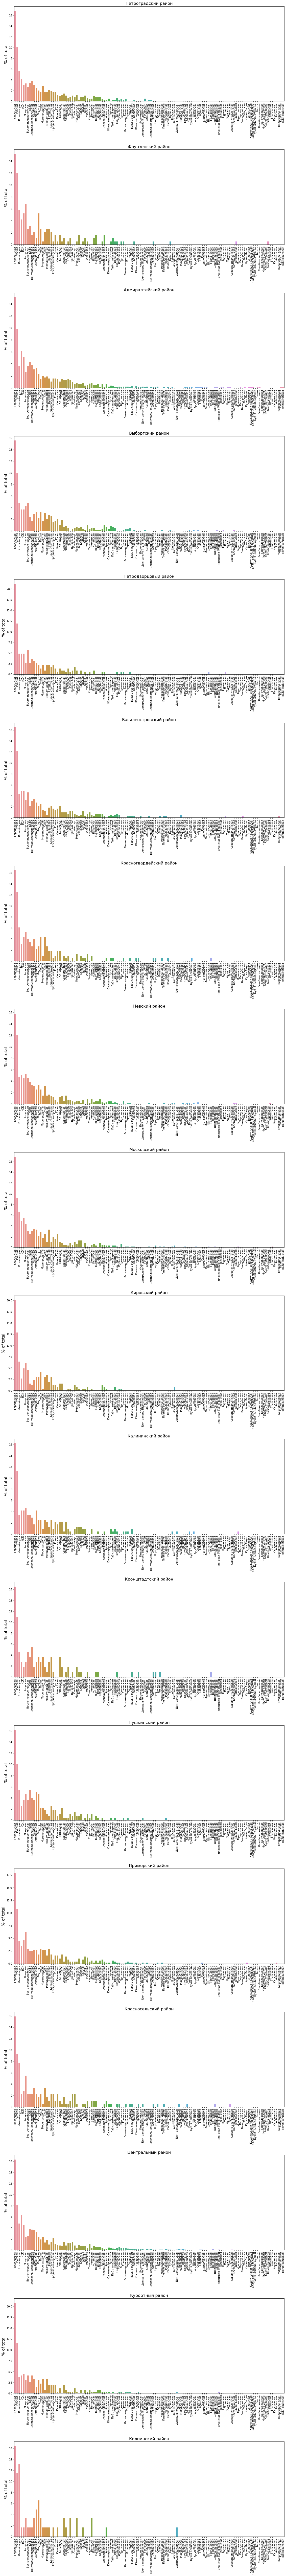

In [174]:
fig, axs = plt.subplots(len(pd_kitchen_types_by_district_perc), 1, figsize=(20, 8*len(pd_kitchen_types_by_district_perc)))

fig.tight_layout(pad=17.0)
for d in range(len(pd_kitchen_types_by_district_perc)):
    bar = sns.barplot(data=pd_kitchen_types_by_district_perc.iloc[d:d+1, :].drop(['total', 'district'], axis=1), ax=axs[d])
    axs[d].set_xticklabels(bar.get_xticklabels(), fontsize=10, rotation=90)
    axs[d].set_ylabel('% of total', fontsize=16)
    axs[d].set_title(pd_kitchen_types_by_district_perc.loc[d, 'district'].capitalize() + ' район', fontsize=16)
plt.show()

In [14]:
def highlight_cols(x):
    color = sns.xkcd_rgb['sand']
    
    return ['background-color: %s' % color] * len(x)

In [15]:
# create top of restaurants by average rating and number of reviews
#     and show top 10

top10byavg = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__mean').desc(),
          F.col('comments.comments__count').desc())

top10byavg.limit(10).toPandas().style.apply(highlight_cols, subset=pd.IndexSlice[:, ['rating__mean', 'comments__count']])

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Birch,"ул. Кирочная д. 3, Санкт-Петербург 191028 Россия",центральный,5.000000,4.500000,4.500000,4.500000,None,869
1,Пхали-Хинкали,"проспект Юрия Гагарина, 71, Санкт-Петербург 196143 Россия",московский,5.000000,4.500000,4.500000,4.500000,None,764
2,Mr. Bo,"Манежный переулок, 2, Санкт-Петербург 191014 Россия",центральный,5.000000,5.000000,5.000000,4.500000,None,452
3,Пышечка,"наб. кан. Грибоедова, 56-58, Санкт-Петербург 190031 Россия",адмиралтейский,5.000000,4.500000,4.500000,4.500000,None,364
4,Пхали-Хинкали,"пр-кт Ветеранов, 160, Санкт-Петербург 198264 Россия",кировский,5.000000,4.500000,4.500000,4.500000,None,341
5,Public Cafe,"Ефимова, 1/4 Сенная площадь, Санкт-Петербург 190031 Россия",адмиралтейский,5.000000,5.000000,4.500000,5.000000,None,319
6,"Ресторан ""Долма""","ул. Почтамтская, д. 1, Санкт-Петербург 190000 Россия",адмиралтейский,5.000000,5.000000,5.000000,4.500000,None,264
7,Ешь Фреш,"Московский проспект 4а, Санкт-Петербург 141021 Россия",московский,5.000000,5.000000,5.000000,4.500000,None,250
8,Julia Child Bistro,"ул. Гражданская, 27 Вознесенский пр-т, 30, Санкт-Петербург 190031 Россия",кронштадтский,5.000000,5.000000,5.000000,5.000000,None,232
9,FULL HOUSE Restobar,"Наб. Канала Грибоедова, 27 Санкт-Петербург, Санкт-Петербург 191186 Россия",центральный,5.000000,5.000000,5.000000,5.000000,None,196


In [16]:
# create top of restaurants by food rating and number of reviews
#     and show top 10

top10byfood = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__food').desc(),
          F.col('comments.comments__count').desc())

top10byfood.limit(10).toPandas().style.apply(highlight_cols, subset=pd.IndexSlice[:, ['rating__food', 'comments__count']])

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Перкорсо,"Вознесенский проспект, д. 1 гостиница ""Four Seasons Hotel Lion Palace St. Petersburg"", 1 этаж, Санкт-Петербург 190000 Россия",адмиралтейский,4.500000,5.000000,5.000000,4.500000,5.000000,910
1,all Seasons,"ул.Большая Морская 34, Санкт-Петербург 190000 Россия",адмиралтейский,4.500000,5.000000,4.500000,4.500000,nan,612
2,Банщики,"Дегтярная ул., 1А, Санкт-Петербург 191024 Россия",центральный,4.500000,5.000000,4.500000,4.500000,nan,454
3,Mr. Bo,"Манежный переулок, 2, Санкт-Петербург 191014 Россия",центральный,5.000000,5.000000,5.000000,4.500000,nan,452
4,Ресторан Вино & Вода,"ул. Чайковского, 17 Oтель Индиго, Санкт-Петербург 191187 Россия",центральный,4.500000,5.000000,4.500000,4.500000,4.500000,394
5,Пхали-Хинкали,"Комендантский пр., д. 27 к. 1, Санкт-Петербург 197371 Россия",приморский,4.500000,5.000000,4.500000,4.500000,nan,392
6,Иль Миланезе,"Литейный пр., 7 Metro Chernyshevskaya, Санкт-Петербург 191028 Россия",центральный,4.500000,5.000000,5.000000,4.500000,nan,374
7,Public Cafe,"Ефимова, 1/4 Сенная площадь, Санкт-Петербург 190031 Россия",адмиралтейский,5.000000,5.000000,4.500000,5.000000,nan,319
8,Укроп на Восстания,"ул. Восстания, 47, Санкт-Петербург 191123 Россия",центральный,4.500000,5.000000,5.000000,4.500000,nan,281
9,"Ресторан ""Долма""","ул. Почтамтская, д. 1, Санкт-Петербург 190000 Россия",адмиралтейский,5.000000,5.000000,5.000000,4.500000,nan,264


In [17]:
# create top of restaurants by atmosphere rating and number of reviews
#     and show top 10

top10byatmosphere = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__atmosphere').desc(),
          F.col('comments.comments__count').desc())

top10byatmosphere.limit(10).toPandas().style.apply(highlight_cols, subset=pd.IndexSlice[:, ['rating__atmosphere', 'comments__count']])

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Перкорсо,"Вознесенский проспект, д. 1 гостиница ""Four Seasons Hotel Lion Palace St. Petersburg"", 1 этаж, Санкт-Петербург 190000 Россия",адмиралтейский,4.500000,5.000000,5.000000,4.500000,5.000000,910
1,Пхали-Хинкали,"Просвещения пр-т, 53 корп. 1, Санкт-Петербург 195274 Россия",выборгский,4.500000,4.500000,4.500000,4.500000,5.000000,836
2,Укроп на М.Конюшенной,"ул. Малая Конюшенная, 14, Санкт-Петербург 191186 Россия",центральный,4.500000,4.500000,4.500000,4.500000,5.000000,833
3,Укроп на 7-ой Линии,"7-я Линия В.О., 30, Санкт-Петербург 199004 Россия",василеостровский,4.500000,4.500000,5.000000,4.500000,5.000000,404
4,Пельмения на Разъезжей,"ул. Разъезжая, д. 10/15, Санкт-Петербург 191002 Россия",курортный,4.500000,4.500000,4.500000,4.500000,5.000000,327
5,Изба Русская кухня,"ул. Садовая, 67, Санкт-Петербург 190068 Россия",адмиралтейский,4.500000,4.500000,4.500000,4.500000,5.000000,320
6,I'm Thankful For Today,"ул. Гороховая, 24, Санкт-Петербург 191186 Россия",адмиралтейский,4.500000,4.500000,4.500000,4.500000,5.000000,302
7,Макарена,"Московский проспект, 206, Санкт-Петербург Россия",московский,4.500000,4.500000,4.500000,4.500000,5.000000,280
8,Граф-Ин,"Конногвардейский бульвар, д. 4, Санкт-Петербург 190000 Россия",адмиралтейский,4.500000,4.500000,4.500000,4.500000,5.000000,258
9,Ресторан Русская Рыбалка в Комарово,"Приморское ш, 452 а, Комарово, Санкт-Петербург 197733 Россия",приморский,4.000000,4.500000,4.500000,4.000000,5.000000,256


In [18]:
# create top of restaurants by service rating and number of reviews
#     and show top 10

top10byatmosphere = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__service').desc(),
          F.col('comments.comments__count').desc())

top10byatmosphere.limit(10).toPandas().style.apply(highlight_cols, subset=pd.IndexSlice[:, ['rating__service', 'comments__count']])

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Северянин,"Столярный переулок, д. 18 наб. кан. Грибоедова, 69, Санкт-Петербург 190031 Россия",адмиралтейский,4.500000,4.500000,5.000000,4.500000,4.500000,1437
1,Restaurant Schengen,"Кирочная ул., 5, Санкт-Петербург 191028 Россия",центральный,4.500000,4.500000,5.000000,4.500000,4.500000,943
2,Перкорсо,"Вознесенский проспект, д. 1 гостиница ""Four Seasons Hotel Lion Palace St. Petersburg"", 1 этаж, Санкт-Петербург 190000 Россия",адмиралтейский,4.500000,5.000000,5.000000,4.500000,5.000000,910
3,Dans Le Noir?,"Биржевой пер., 4 Васильевский остров, Санкт-Петербург 199004 Россия",петроградский,4.500000,4.500000,5.000000,4.500000,4.500000,848
4,Тройка,"Загородный проспект, д. 27, Санкт-Петербург 191180 Россия",курортный,4.500000,4.500000,5.000000,4.500000,4.000000,665
5,Mr. Bo,"Манежный переулок, 2, Санкт-Петербург 191014 Россия",центральный,5.000000,5.000000,5.000000,4.500000,nan,452
6,Укроп на 7-ой Линии,"7-я Линия В.О., 30, Санкт-Петербург 199004 Россия",василеостровский,4.500000,4.500000,5.000000,4.500000,5.000000,404
7,Иль Миланезе,"Литейный пр., 7 Metro Chernyshevskaya, Санкт-Петербург 191028 Россия",центральный,4.500000,5.000000,5.000000,4.500000,nan,374
8,Ресторан Sintoho,"Вознесенский пр-т, 1, Санкт-Петербург 190000 Россия",адмиралтейский,4.500000,4.500000,5.000000,4.500000,4.500000,321
9,Укроп на Восстания,"ул. Восстания, 47, Санкт-Петербург 191123 Россия",центральный,4.500000,5.000000,5.000000,4.500000,nan,281


In [19]:
# create top of restaurants by price quality rating and number of reviews
#     and show top 10

top10byatmosphere = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__price_quality').desc(),
          F.col('comments.comments__count').desc())

top10byatmosphere.limit(10).toPandas().style.apply(highlight_cols, subset=pd.IndexSlice[:, ['rating__price_quality', 'comments__count']])

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Public Cafe,"Ефимова, 1/4 Сенная площадь, Санкт-Петербург 190031 Россия",адмиралтейский,5.000000,5.000000,4.500000,5.000000,None,319
1,Julia Child Bistro,"ул. Гражданская, 27 Вознесенский пр-т, 30, Санкт-Петербург 190031 Россия",кронштадтский,5.000000,5.000000,5.000000,5.000000,None,232
2,FULL HOUSE Restobar,"Наб. Канала Грибоедова, 27 Санкт-Петербург, Санкт-Петербург 191186 Россия",центральный,5.000000,5.000000,5.000000,5.000000,None,196
3,Home Cafe Петергоф,"ул. Шахматова, 14/1, Петергоф, Санкт-Петербург 198504 Россия",петродворцовый,5.000000,5.000000,5.000000,5.000000,None,182
4,BLOODY MARY Bar & Grill,"Мучной переулок, 9/27, Санкт-Петербург 191023 Россия",центральный,5.000000,5.000000,5.000000,5.000000,None,180
5,Meal,"Литейный пр., 17-19, Санкт-Петербург 191028 Россия",центральный,5.000000,5.000000,5.000000,5.000000,None,137
6,Вайн Гог,"Малая Конюшенная, 7, Санкт-Петербург 191186 Россия",центральный,5.000000,5.000000,5.000000,5.000000,None,115
7,Четыре Сыра,"ул. Караванная, 5, Санкт-Петербург 191023 Россия",центральный,4.500000,5.000000,5.000000,5.000000,None,87
8,Meat Bar,"ул. Жуковского, 22, Санкт-Петербург 191014 Россия",центральный,4.500000,5.000000,4.500000,5.000000,None,84
9,Uno Due Tre Cafe,"ул. Тверская, 20, Санкт-Петербург 191124 Россия",колпинский,5.000000,5.000000,5.000000,5.000000,None,82


In [20]:
# function to calculate correlation matrix
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]['{0}({1})'.format(method, vector_col)].values
    
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

corr_matrix = correlation_matrix(df[['rating.*']].dropna(), df[['rating.*']].columns)
corr_matrix

,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere
rating__mean,1.000000,0.710957,0.723425,0.658479,0.507039
rating__food,0.710957,1.000000,0.721115,0.658470,0.519018
rating__service,0.723425,0.721115,1.000000,0.598734,0.547008
rating__price_quality,0.658479,0.658470,0.598734,1.000000,0.362651
rating__atmosphere,0.507039,0.519018,0.547008,0.362651,1.000000


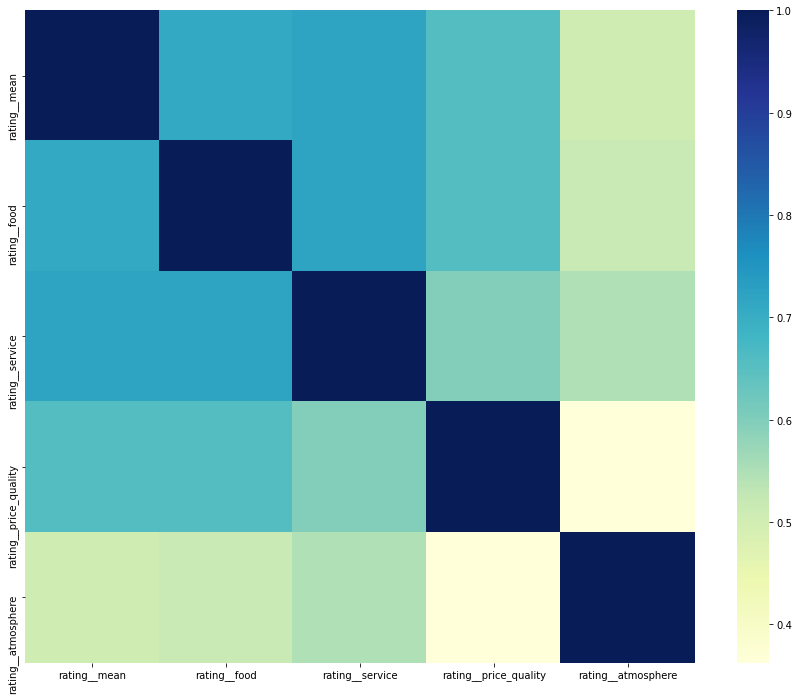

In [21]:
# show heatmap by correlation matrix values

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap="YlGnBu")
plt.show()

###     As we can see, the quality of service rating has the greatest impact on the final rating that the visitor puts. Food rating has a slightly lesser impact. Next one is the price-quality rating. And least of all the atmosphere rating.

#  

In [22]:
# collect coords of restaurants

coords = df.filter(F.col('coords').isNotNull()).select('coords.*').collect()
coords = pd.DataFrame({
                'lon': [lon.coords__lon for lon in coords],
                'lat': [lat.coords__lat for lat in coords]})

In [23]:
# collect coords of restaurants

coords = df.filter(F.col('coords').isNotNull()).select('rating.rating__mean', 'coords.*').collect()
coords = pd.DataFrame({
                'rating': [rate.rating__mean for rate in coords],
                'lon': [lon.coords__lon for lon in coords],
                'lat': [lat.coords__lat for lat in coords]})

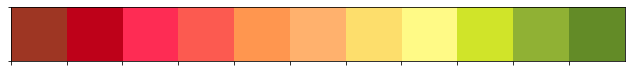

In [47]:
palette = {
            0: sns.xkcd_rgb['brownish red'],
            0.5: sns.xkcd_rgb['scarlet'],
            1: sns.xkcd_rgb['reddish pink'],
            1.5: sns.xkcd_rgb['coral'],
            2: sns.xkcd_rgb['pastel orange'],
            2.5: sns.xkcd_rgb['apricot'],
            3: sns.xkcd_rgb['pale gold'],
            3.5: sns.xkcd_rgb['manilla'],
            4: sns.xkcd_rgb['sickly yellow'],
            4.5: sns.xkcd_rgb['avocado'],
            5: sns.xkcd_rgb['mossy green']
        }
sns.palplot(palette.values())

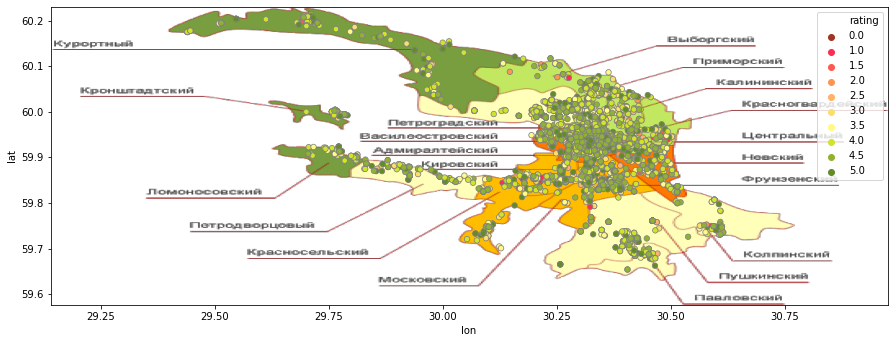

In [56]:
# plot restaurants places on map

fig, ax = plt.subplots(figsize=(15, 15))
img = plt.imread("common/map.png")
ax.imshow(img, extent=[29.140176, 30.975743, 59.576825, 60.229601])
sns.scatterplot(coords['lon'], coords['lat'], hue=coords['rating'], palette=palette,  ax=ax, s=30, edgecolor='grey')
plt.show()

In [57]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [58]:
stop_words = set(stopwords.words('russian') + list(string.punctuation))

#function to tokenize given comments
def tokenize(text, is_porter=False, is_lemm=False):
    tokens = word_tokenize(text)
    
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]
    tokens = [w for w in tokens if len(w) > 1]
    
    if is_porter:
        porter = PorterStemmer()
        tokens = [porter.stem(w) for w in tokens]
    if is_lemm:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    
    return tokens

In [59]:
# function to plot cloud of words by id or name of restaurant
def show_restaurant_wordcloud(df, _id=None, name=None, collocations=True, collocation_threshold=30, tag_type=None, tag_type2='None', tag_type3='None', tag_type4='None', tag_type5='None'):
    if _id:
        row = df.filter(df['_id.oid'] == _id)
    elif name:
        row = df.filter(df['name'] == name)
    else:
        return
        
    comments = list(map(lambda x: x.replace('\n', ' ').lower(),
                        row.select('comments.comments.comment__body').take(1)[0].comment__body))
    tokens = tokenize(' '.join(comments))
    if tag_type:
        tokens = [tag[0] for tag in nltk.pos_tag(tokens, lang='rus') 
                    if tag[1].find(tag_type) != -1 or tag[1].find(tag_type2) != -1 or
                     tag[1] == tag_type3 or tag[1] == tag_type4 or tag[1] == tag_type5]
    
    plt.figure(figsize=(10, 6))
    plt.title(name)
    plt.axis("off")
    plt.imshow(WordCloud(collocations=collocations, collocation_threshold=collocation_threshold, background_color="white").generate(" ".join(tokens)), 
           interpolation='bilinear', aspect='auto')

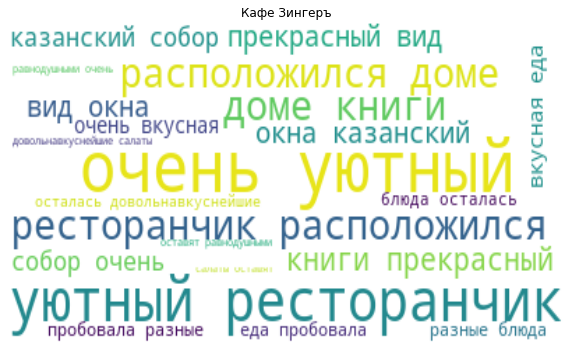

In [60]:
show_restaurant_wordcloud(df, name='Кафе Зингеръ', tag_type='A=', tag_type2='ADV', tag_type3='V', tag_type4='S', tag_type5='PART')

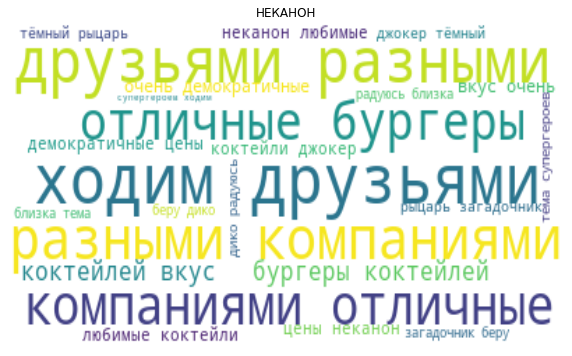

In [64]:
show_restaurant_wordcloud(df, name='НЕКАНОН', tag_type='A=', tag_type2='ADV', tag_type3='V', tag_type4='S', tag_type5='PART')